## Figure 4

In [1]:
import numpy as np
import itertools
from scipy.stats import binned_statistic, linregress, pearsonr

import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import Normalize

import pandas as pd

from sklearn.linear_model import LinearRegression

### Subplot (d) -- meta-degree distribution

Read meta-graph

In [2]:
mg_df = pd.read_csv("metagraph_edgelist_threshold.csv")
mg_df

,Unnamed: 0,bodyId_1,bodyId_2,minimum_distance_threshold
0,0,2128109571,2252931126,20
1,1,2128109571,2128117878,25
2,2,2128109571,2128109762,70
3,3,2128109571,1942249730,150
4,4,2128109571,2190860581,15
...,...,...,...,...
592435,592435,2252931070,2128109217,25
592436,592436,2252931070,1910873766,10
592437,592437,2252931070,1973616386,150
592438,592438,2252931070,5813002148,150


In [3]:
T=1. #Delta lambda

In [4]:
metadeg = pd.Series(0,index=np.unique(mg_df[['bodyId_1','bodyId_2']].values))

In [5]:
metadeg.update(mg_df[mg_df.minimum_distance_threshold<=T].groupby('bodyId_1').size())
metadeg

543702186     0
632570417     1
695124651     4
730709173     0
791527493     1
             ..
5901211311    1
5901216066    0
5901220378    8
5901225595    4
7112616299    1
Length: 2972, dtype: int64

Text(0.5, 0, 'Meta-degree $(k)$')

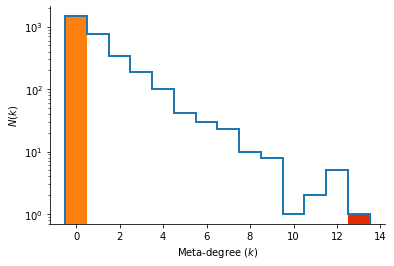

In [6]:
maxdeg = metadeg.max()
bins = np.arange(0,maxdeg+2)-.5
plt.hist(metadeg,bins=bins,histtype='step',linewidth=2)
plt.hist([0]*(metadeg==0).sum(),bins=[-.5,.5],linewidth=2)
plt.hist([maxdeg],bins=[-.5+maxdeg,.5+maxdeg],linewidth=2,color="#E72A00")
plt.yscale('log')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel(r'$N(k)$')
plt.xlabel(r'Meta-degree $(k)$')

### Figure (e) -- meta-degree - synapse correlations

Read the connectome (synapse network) of the sample we are working with

In [7]:
conn_df = pd.read_csv("connectome_edgelist.csv")
conn_df

,Unnamed: 0,bodyId_pre,bodyId_post,roi,weight
0,0,543702186,791527493,PLP(R),2
1,1,543702186,1749628974,PLP(R),1
2,2,543702186,2130504694,AME(R),1
3,3,543702186,2161872840,ME(R),1
4,4,543702186,2254640190,ME(R),1
...,...,...,...,...,...
35696,35709,7112616299,5813045602,SPS(R),3
35697,35710,7112616299,5813046248,NotPrimary,1
35698,35711,7112616299,5813056759,NotPrimary,2
35699,35712,7112616299,5813069193,AME(R),1


Connectome degree of neurons

In [8]:
num_synapses = conn_df.groupby('bodyId_pre')['weight'].sum()+conn_df.groupby('bodyId_post')['weight'].sum()

In [9]:
num_unique_synapses = conn_df.groupby('bodyId_pre')['weight'].count()+conn_df.groupby('bodyId_post')['weight'].count()

In [10]:
df = pd.DataFrame([num_synapses,num_unique_synapses]).T
df.columns = ['num_synapses','num_unique_synapses']
df

,num_synapses,num_unique_synapses
543702186,38.0,24.0
632570417,72.0,38.0
695124651,690.0,75.0
730709173,12.0,12.0
791527493,134.0,87.0
...,...,...
5901211311,4.0,4.0
5901216066,40.0,28.0
5901220378,80.0,55.0
5901225595,60.0,41.0


In [11]:
df['metadegree']=metadeg
df

,num_synapses,num_unique_synapses,metadegree
543702186,38.0,24.0,0
632570417,72.0,38.0,1
695124651,690.0,75.0,4
730709173,12.0,12.0,0
791527493,134.0,87.0,1
...,...,...,...
5901211311,4.0,4.0,1
5901216066,40.0,28.0,0
5901220378,80.0,55.0,8
5901225595,60.0,41.0,4


LinregressResult(slope=0.35579879912070084, intercept=2.8395162328935077, rvalue=0.5093635824159848, pvalue=6.326372026716778e-186, stderr=0.011327578625484945)


Text(0, 0.5, 'Number of synapses')

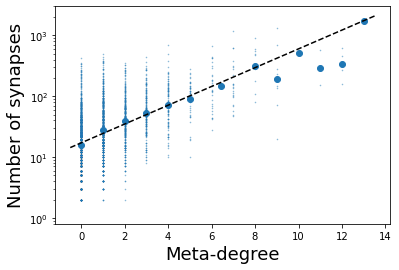

In [12]:
meta_deg = df['metadegree']
conn_deg = df['num_synapses']
plt.scatter(meta_deg,conn_deg,s=.3,alpha=.5)

mask =  (conn_deg>0)

res = linregress(meta_deg[mask],np.log(conn_deg[mask]))
print(res)

lfs = 18


bins_md = np.linspace(-0.5,13.5,14)

bmd_md,be,bn   = binned_statistic(meta_deg[mask], meta_deg[mask], statistic='mean', bins=bins_md)
bcd_md,be,bn   = binned_statistic(meta_deg[mask], np.log(conn_deg[mask]), statistic='mean', bins=bins_md)

plt.plot(bmd_md,np.exp(bcd_md),'o',linewidth=2,markersize=6,label=fr'$\Delta \lambda={T/17.97/2:.2}$')
plt.plot(bins_md, np.exp(res.slope*bins_md+res.intercept),'--k')

plt.ylim(bottom=.8,top=3000)

plt.yscale('log')
plt.xlabel('Meta-degree',fontsize=lfs)
plt.ylabel('Number of synapses',fontsize=lfs)

### Final figure

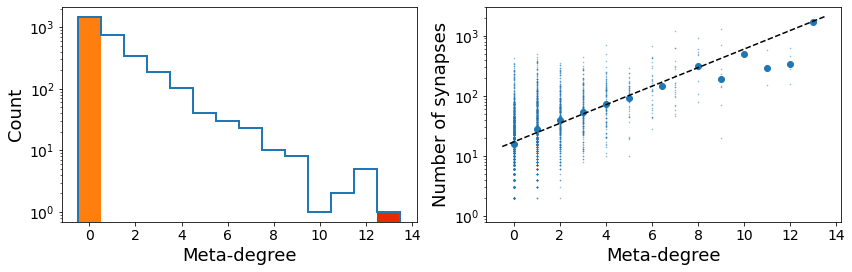

In [13]:
plt.rcParams.update({'font.size': 14})
fig,axs = plt.subplots(1,2,figsize=(12,4))

lw=1
lw2=1.5
ps = 4.5
lfs = 18
legfs = 14

plt.sca(axs[0])

maxdeg = metadeg.max()
bins = np.arange(0,maxdeg+2)-.5
plt.hist(metadeg,bins=bins,histtype='step',linewidth=2)
plt.hist([0]*(metadeg==0).sum(),bins=[-.5,.5],linewidth=2)
plt.hist([maxdeg],bins=[-.5+maxdeg,.5+maxdeg],linewidth=2,color="#E72A00")
plt.yscale('log')
plt.ylabel(r'Count',fontsize=lfs)
plt.xlabel(r'Meta-degree',fontsize=lfs)



plt.sca(axs[1])

meta_deg = df['metadegree']
conn_deg = df['num_synapses']
plt.scatter(meta_deg,conn_deg,s=.3,alpha=.5)

mask =  (conn_deg>0)

res = linregress(meta_deg[mask],np.log(conn_deg[mask]))

bins_md = np.linspace(-0.5,13.5,14)

bmd_md,be,bn   = binned_statistic(meta_deg[mask], meta_deg[mask], statistic='mean', bins=bins_md)
bcd_md,be,bn   = binned_statistic(meta_deg[mask], np.log(conn_deg[mask]), statistic='mean', bins=bins_md)

plt.plot(bmd_md,np.exp(bcd_md),'o',linewidth=2,markersize=6,label=fr'$\Delta \lambda={T/17.97/2:.2}$')
plt.plot(bins_md, np.exp(res.slope*bins_md+res.intercept),'--k')

plt.ylim(bottom=.8,top=3000)

plt.yscale('log')
plt.xlabel('Meta-degree',fontsize=lfs)
plt.ylabel('Number of synapses',fontsize=lfs)


plt.tight_layout()